In [1]:
import gzip
import pickle
import random
import numpy as np
import tensorflow as tf

In [2]:
def load_data():
    f = gzip.open('mnist.pkl.gz','rb')
    x,y,z = pickle.load(f,encoding='iso-8859-1')
    print("x = ",len(x))
    print(x)
    return (x,y,z)

In [3]:
def vectorized_result(y):
    e = np.zeros((10,1))
    e[y]=1.0
    return e

In [4]:
tr_d,va_d,te_d = load_data()

x =  2
(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32), array([5, 0, 4, ..., 8, 4, 8]))


In [5]:
trainning_inputs = [np.reshape(x,(784,1)) for x in tr_d[0]]
training_results = [vectorized_result(y) for y in tr_d[1]]
training_data = [(x,y) for x,y in zip(trainning_inputs,training_results)]
validation_inputs = [np.reshape(x,(784,1)) for x in va_d[0]]
validation_results = [vectorized_result(y) for y in va_d[1]]
test_inputs = [np.reshape(x,(784,1)) for x in te_d[0]]
test_results = [vectorized_result(y) for y in te_d[1]]

In [6]:
X_train = np.squeeze(np.array(trainning_inputs))
Y_train = np.squeeze(np.array(training_results))
X_validation = np.squeeze(np.array(validation_inputs))
Y_validation = np.squeeze(np.array(validation_results))
X_test = np.squeeze(np.array(test_inputs))
Y_test = np.squeeze(np.array(test_results))

In [7]:
print(X_train.shape, Y_train.shape)
print(X_validation.shape, Y_validation.shape)
print(X_test.shape, Y_test.shape)
print(type(X_train), type(Y_train))

(50000, 784) (50000, 10)
(10000, 784) (10000, 10)
(10000, 784) (10000, 10)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [8]:
def create_placeholder(n_x, n_y):
    X = tf.placeholder(tf.float32, [None, n_x])
    Y = tf.placeholder(tf.float32, [None, n_y])
    
    return X, Y

In [9]:
def initialize_parameters():
    
    W1 = tf.get_variable("W1", [784, 512], initializer = tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable("b1", [1, 512], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [512, 28], initializer = tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable("b2", [1, 28], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [28, 10], initializer = tf.contrib.layers.xavier_initializer())
    b3 = tf.get_variable("b3", [1, 10], initializer = tf.zeros_initializer())
    
    parameters = {"W1" : W1, 
                  "b1" : b1,
                  "W2" : W2, 
                  "b2" : b2, 
                  "W3" : W3, 
                  "b3" : b3}
    return parameters

In [10]:
def forward_propagation(X, parameters):
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(X, W1), b1)
    A1 = tf.nn.sigmoid(Z1)
    Z2 = tf.add(tf.matmul(A1, W2), b2)
    A2 = tf.nn.sigmoid(Z2)
    Z3 = tf.add(tf.matmul(A2, W3), b3)
    A3 = tf.nn.sigmoid(Z3)
    
    return A3

In [11]:
def compute_cost(A3, Y):
    
    #logits = tf.transpose(A3)
    #labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = A3, labels = Y))

    return cost

In [12]:
import math

def random_mini_batches(X, Y, mini_batch_size = 64,seed=0):
    
    m = X_train.shape[0]
    mini_batches = []
    np.random.seed(seed)
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,: ]
    shuffled_Y = Y[permutation,: ]
    
    num_complete_minibatches = math.floor(m / mini_batch_size)
    
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k*mini_batch_size : k*mini_batch_size + mini_batch_size,:]
        mini_batch_Y = shuffled_Y[k*mini_batch_size : k*mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches*mini_batch_size : m,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches*mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    return mini_batches

In [13]:
import matplotlib.pyplot as plt
import time

%matplotlib inline

def model(X_train, Y_train, X_test, Y_test, 
          learning_rate=0.1, num_epochs=15, minibatch_size=100, print_cost=True):
    
    tf.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    (m, n_x) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []
    
    X, Y = create_placeholder(n_x, n_y)
    parameters = initialize_parameters()
    
    A3 = forward_propagation(X, parameters)
    cost = compute_cost(A3, Y)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
    
    with tf.Session() as sess:
        
        init = tf.global_variables_initializer()
        sess.run(init)
        
        start = time.time()
        
        for epoch in range(num_epochs):
            
            start_time = time.time()
            epoch_cost = 0.
            num_minibatches = int(m/minibatch_size)
            #print("num_minibatches:"+str(num_minibatches))
            seed = seed+1
            mini_batches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in mini_batches:
                
                (minibatch_X, minibatch_Y) = minibatch
                
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict = {X : minibatch_X, Y : minibatch_Y})

                epoch_cost += minibatch_cost/num_minibatches
            
            if print_cost == True and epoch % 1 == 0:
                print("Cost after epochs %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
        end = time.time() - start
        print("total epoch time cost:"+str(end))

        plt.plot(np.squeeze(costs))
        plt.xlabel('iterations(per tens)')
        plt.ylabel('cost')
        plt.title("learning rate="+str(learning_rate))
        
        parameters = sess.run(parameters)
        print("parameters have been trained")
        
        correct_prediction = tf.equal(tf.argmax(A3, 1), tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
                      
        print("Train accuracy:", accuracy.eval({X : X_train, Y : Y_train}))
        print("Test accuracy:", accuracy.eval({X : X_test, Y : Y_test}))
        
        return parameters

Cost after epochs 0: 2.281525
Cost after epochs 1: 2.196885
Cost after epochs 2: 2.046253
Cost after epochs 3: 1.919040
Cost after epochs 4: 1.848150
Cost after epochs 5: 1.802950
Cost after epochs 6: 1.769295
Cost after epochs 7: 1.742144
Cost after epochs 8: 1.719818
Cost after epochs 9: 1.701517
Cost after epochs 10: 1.686477
Cost after epochs 11: 1.673961
Cost after epochs 12: 1.663358
Cost after epochs 13: 1.654315
Cost after epochs 14: 1.646542
total epoch time cost:14.606969118118286
parameters have been trained
Train accuracy: 0.8609
Test accuracy: 0.8662


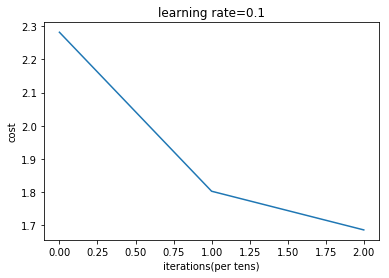

In [14]:
parameteres = model(X_train, Y_train, X_test, Y_test)